<a href="https://colab.research.google.com/github/hasan-rakibul/AI-cybersec/blob/main/lab_10/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI-driven anomaly detection: leveraging ARIMA forecasting technique
Forecasting is a technique used to predict future trends based on historical data. In the context of cybersecurity, forecasting can be used to identify patterns and anomalies that may indicate a potential security threat. By analyzing patterns in data over time, forecasting algorithms can help detect anomalies in real-time, allowing organizations to proactively respond to potential security incidents before they become major issues.

In this lab, we will use ARIMA (Autoregressive Integrated Moving Average) forecasting algorithm. ARIMA is a commonly used time series forecasting model. It is a powerful statistical technique for analysing and predicting patterns in data, particularly in cases where the data is non-stationary or has a trend.

ARIMA models are based on three components:

- Autoregression (AR): A linear regression model that uses past values to predict future values. An AR(p) model uses p past values to predict the next value in the series. For example, an AR(2) model for the stock price of a company would use the last two days' stock prices to predict the next day's stock price.
- Integrated (I): Integration involves transforming the time series to make it stationary, which means that its statistical properties (such as mean and variance) do not change over time. This is important because many time series have trends or seasonal patterns that make them non-stationary. One common way to transform a time series is to difference it, which involves subtracting each observation from the previous observation. If the original time series is denoted by $Y_t$, the differenced time series is denoted by $Y_t - Y_{t-1}$. For example, if you were trying to forecast the number of monthly visitors to a website, differencing the data could help remove any trends or seasonality.
- Moving Average (MA): A model that uses past forecast errors to predict future values. In an MA(q) model, the next value in the series is a function of the past q errors. For example, an MA(1) model for the daily temperature would use yesterday's forecast error to predict today's temperature.

ARIMA models use a combination of these three components to model the time series data and predict future values.

**Reference book:** Chio, C., & Freeman, D. (2018). *Machine learning and security: Protecting systems with data and algorithms* (First edition). O’Reilly Media. (page 95)

**Reference programs:** https://github.com/oreilly-mlsec/book-resources/blob/master/chapter3/arima-forecasting.ipynb (Updated and bug fixed)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

## Dataset

You can find the datasets at [https://github.com/oreilly-mlsec/book-resources/tree/master/chapter3/datasets/cpu-utilization](https://github.com/oreilly-mlsec/book-resources/tree/master/chapter3/datasets/cpu-utilization)

Download the datasets (`cpu-train-a.csv`, `cpu-test-a.csv`, `cpu-train-b.csv`, `cpu-test-b.csv`), and keep them in your Google Drive folder (e.g., `Colab Notebooks/AICS/` folder)

Mount your Google Drive from the "Files" menu.

In [2]:
# Read in the training and testing dataset files
data_train_a = pd.read_csv(
      '/content/drive/MyDrive/Colab Notebooks/AICS/cpu-train-a.csv'
  )

data_test_a = pd.read_csv(
      '/content/drive/MyDrive/Colab Notebooks/AICS/cpu-test-a.csv'
  )

In [3]:
data_train_a.sample(5)

,datetime,cpu
354,2017-01-28 00:36:00,0.82
137,2017-01-27 20:59:00,1.37
131,2017-01-27 20:53:00,1.15
257,2017-01-27 22:59:00,1.85
298,2017-01-27 23:40:00,1.67


In [4]:
print('Train data shape:', data_train_a.shape)
print('Test data shape:', data_test_a.shape)

Train data shape: (420, 2)
Test data shape: (60, 2)


Text(0.5, 1.0, 'CPU Utilisation')

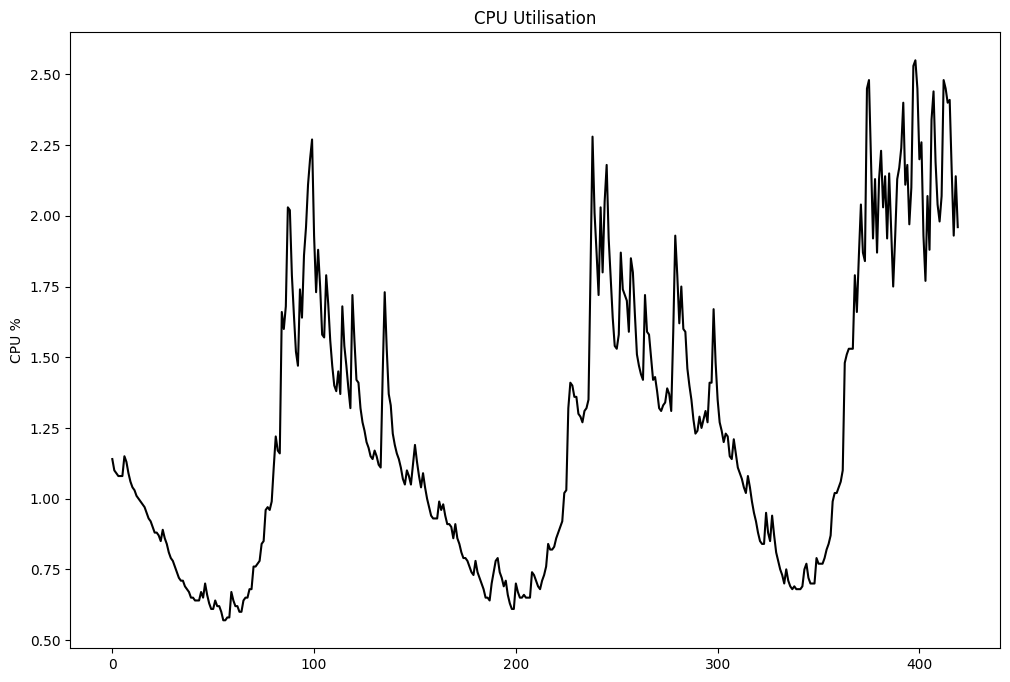

In [5]:
plt.figure(figsize=(12, 8))
plt.plot(data_train_a['cpu'], color='black')
plt.ylabel('CPU %')
plt.title('CPU Utilisation')

## Build the ARIMA model

In [6]:
model_a = ARIMA(
    data_train_a['cpu'].to_numpy(),
    order=(11, 0, 11) # (AR order, differencing order, MA order)
)

Documentation of ARIMA implementation by `statsmodels` is [here](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html).

There are some tricks to determining the [AR and MA orders](https://people.duke.edu/~rnau/411arim3.htm) and the [differencing order](https://people.duke.edu/~rnau/411arim2.htm). But you can also try with different values to see what work best for the dataset &ndash; hyperparameter tuning.

To oversimplify matters, AR and MA orders are needed to correct any residual autocorrelations that remain in the differenced series (i.e., between the time-shifted series and itself). The differencing
order is a term used to make the series stationary — an already stationary series should have a differencing order of 0, a series with a constant average trend (steadily trending upward or downward) should have a differencing order of 1, etc.

## Running the ARIMA model with necessary plotting

In [ ]:
model_a_fit = model_a.fit()

Text(0.5, 1.0, 'In-sample prediction (fitting on training data)')

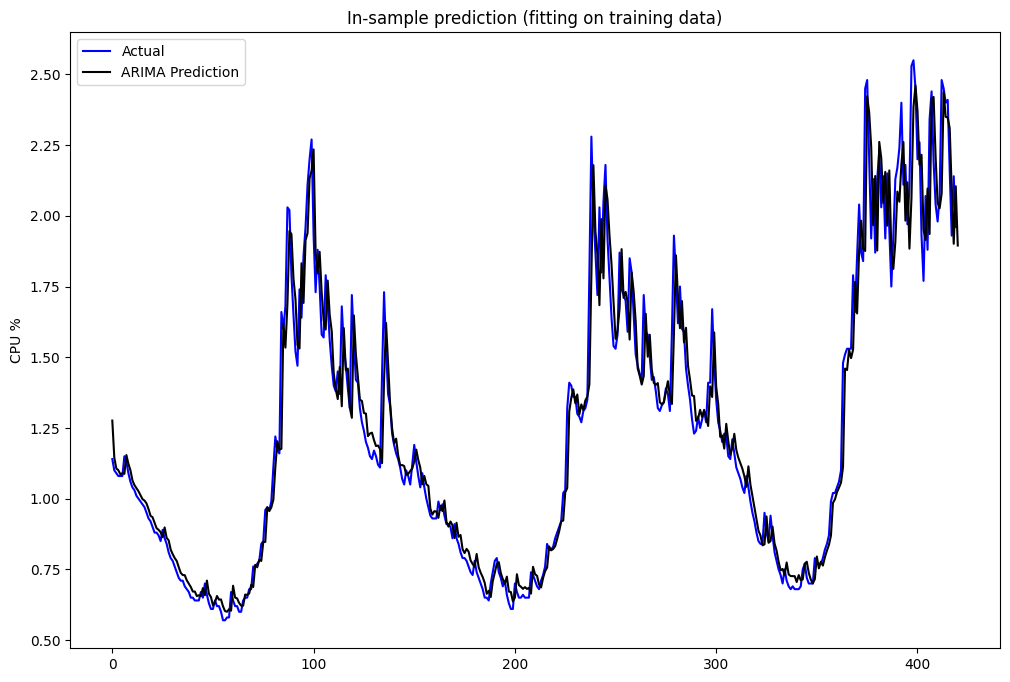

In [8]:
# In-sample prediction or validation
y_pred_train = model_a_fit.predict(
    start=0,
    end=len(data_train_a)
)

plt.figure(figsize=(12, 8))
plt.plot(data_train_a['cpu'].to_numpy(), color='blue', label='Actual')
plt.plot(y_pred_train, color='black', label='ARIMA Prediction')
plt.legend()
plt.ylabel('CPU %')
plt.title('In-sample prediction (fitting on training data)')

As we can see, the results fit the observed data quite well. Next, we can do an in-sample test on the last 60 data points of the training data. The in-sample test is a validation step that treats the last subsection of the series as unknown and performs forecasting for those time steps. This process allows us to evaluate performance of the model without running tests on future/test data:

Text(0.5, 1.0, 'Zoomed-in last 60 in-sample prediction')

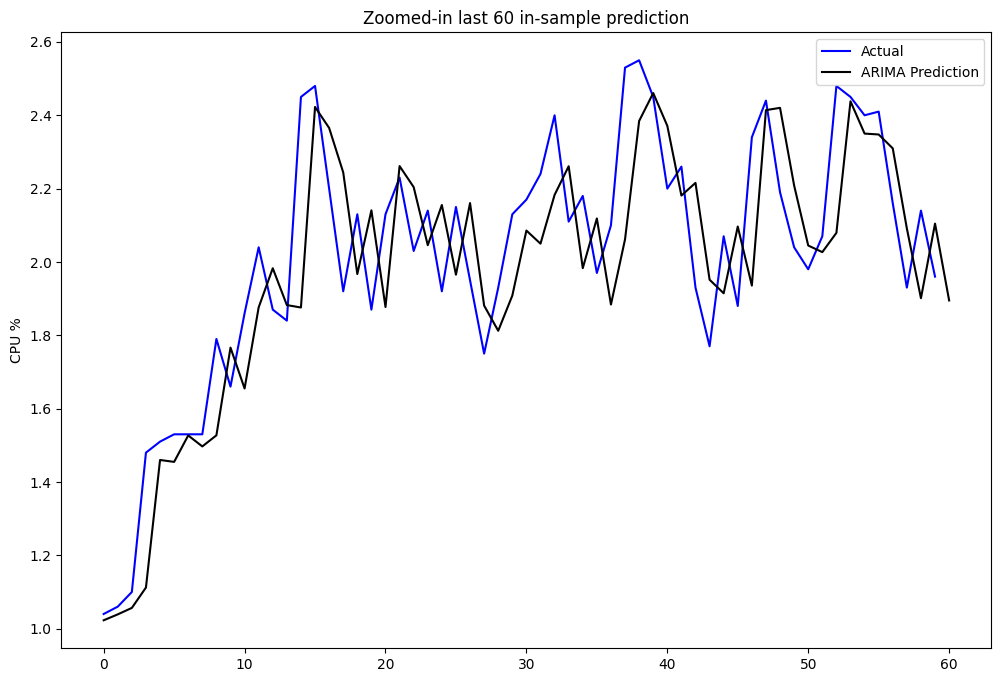

In [9]:
# Zooming in the last 60 in-samples
y_pred_train = model_a_fit.predict(
    start=len(data_train_a)-60,
    end=len(data_train_a)
)

plt.figure(figsize=(12, 8))
plt.plot(data_train_a['cpu'].to_numpy()[360:], color='blue', label='Actual')
plt.plot(y_pred_train, color='black', label='ARIMA Prediction')
plt.legend()
plt.ylabel('CPU %')
plt.title('Zoomed-in last 60 in-sample prediction')

The in-sample prediction test looks pretty good because it does not deviate from the original series significantly in phase and amplitude.

Now, let's compare the predicted values with actual values to detect anomalies. Actual observed values are stored in the `data_test_a` variable.

Text(0.5, 1.0, 'Out-of-sample forecast')

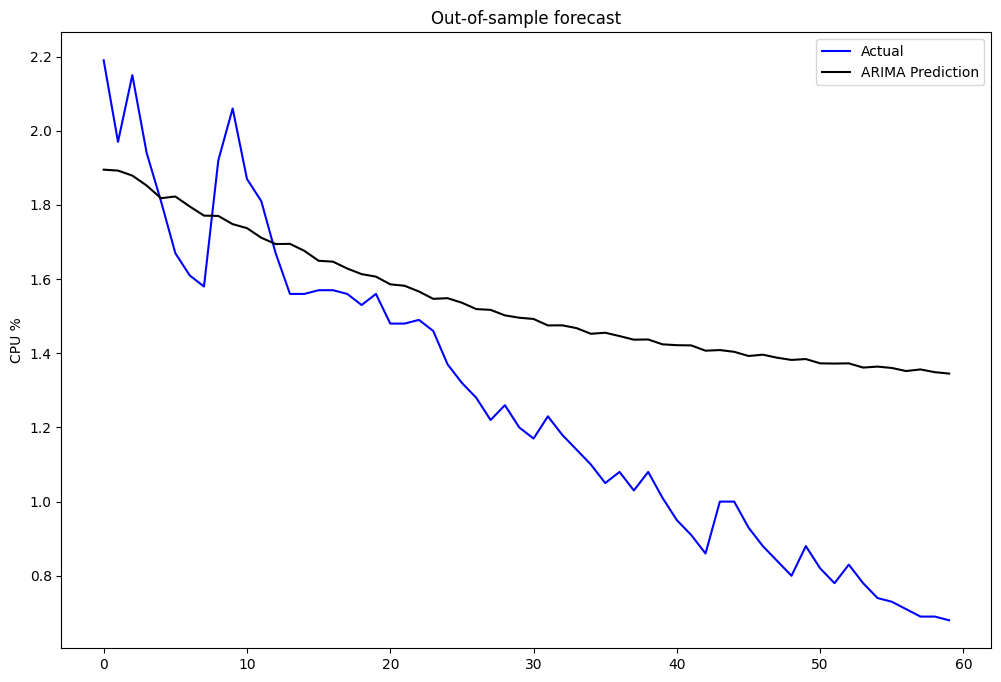

In [10]:
# Out-of-sample forecast
y_pred_test = model_a_fit.forecast(
    steps=len(data_test_a)
)

# Same could be achieved using:
# y_pred_test = model_a_fit.predict(
#     start=len(data_train_a),
#     end=len(data_train_a)+len(data_test_a)
# )

plt.figure(figsize=(12, 8))
plt.plot(data_test_a['cpu'].to_numpy(), color='blue', label='Actual')
plt.plot(y_pred_test, color='black', label='ARIMA Prediction')
plt.legend()
plt.ylabel('CPU %')
plt.title('Out-of-sample forecast')

Since the forecasted CPU utilisation ad observed CPU utilisation are quite similar, it is unlikely that there are any anomalies.

In [11]:
# Calculate metrics
from sklearn.metrics import root_mean_squared_error

rmse = root_mean_squared_error(data_test_a['cpu'].to_numpy(), y_pred_test)
print(f"RMSE: {rmse:.4f}")

RMSE: 0.3746


## Practice task
Use the `cpu-train-b.csv` datasets to fit an ARIMA model and then detect anomalies on `cpu-test-b.csv` dataset.